# Created and implemented for NU GDSC Datathon 2022 by team KZMIT
- Sultan Bauyrzhanuly
- Bekbolat Kurmetbek 

# Initialization


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [30]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
import os
os.listdir('./gdrive/MyDrive/Colab Notebooks/arbuz')

['ArbuzTest.csv', 'ArbuzTrain.csv']

In [32]:
root = './gdrive/MyDrive/Colab Notebooks/arbuz/'
train = pd.read_csv(root+'ArbuzTrain.csv')
test = pd.read_csv(root+'ArbuzTest.csv')
print('train shape', train.shape)
print('test shape', test.shape)

train shape (10984, 39)
test shape (2747, 38)


# Data Exploration

In [33]:
train.head()

,client_id,average_check,number_orders,average_score,items_per_order,is_friend,last_check,last_score,last_scored_after_order_days,last_late_by_minutes,...,items_share_category_19,items_share_category_20,items_share_category_21,items_share_category_22,items_share_category_23,items_share_category_24,items_share_category_25,items_share_category_26,items_share_category_27,is_churn
0,301,49300,7,10.0,23.4286,0,9250.0,NaN,NaN,0,...,0.0,0.0,0.01,0.0,0.00,0.00,0.01,0.0,0.00,0
1,9394,58900,7,10.0,5.4286,0,24547.0,NaN,NaN,0,...,0.0,0.0,0.00,0.0,0.00,0.03,0.00,0.0,0.00,0
2,6680,43100,6,10.0,15.3333,0,6017.0,NaN,NaN,0,...,0.0,0.0,0.00,0.0,0.00,0.22,0.00,0.0,0.02,0
3,4774,33900,8,4.0,9.6250,0,7316.0,NaN,NaN,0,...,0.0,0.0,0.01,0.0,0.06,0.35,0.00,0.0,0.17,0
4,2722,37900,9,10.0,14.2222,0,2175.0,10.0,0.0,0,...,0.0,0.0,0.00,0.0,0.04,0.22,0.00,0.0,0.01,0


In [34]:
train.isnull().sum()

client_id                          0
average_check                      0
number_orders                      0
average_score                   1797
items_per_order                    0
is_friend                          0
last_check                         5
last_score                      7196
last_scored_after_order_days    7196
last_late_by_minutes               0
is_last_order_fullfilled           0
items_share_category_1             0
items_share_category_2             0
items_share_category_3             0
items_share_category_4             0
items_share_category_5             0
items_share_category_6             0
items_share_category_7             0
items_share_category_8             0
items_share_category_9             0
items_share_category_10            0
items_share_category_11            0
items_share_category_12            0
items_share_category_13            0
items_share_category_14            0
items_share_category_15            0
items_share_category_16            0
i

In [35]:
train['is_churn'].value_counts()

0    8505
1    2479
Name: is_churn, dtype: int64

Text(0.5, 1.0, '% of churn')

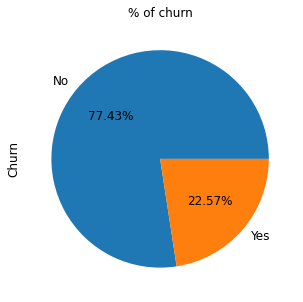

In [36]:
ax = (train['is_churn'].value_counts()*100.0 /len(train))\
.plot.pie(autopct='%.2f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('% of churn', fontsize = 12)

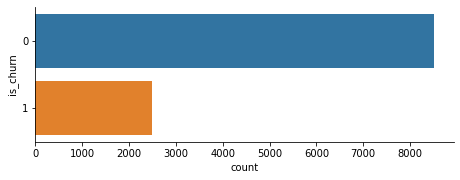

In [37]:
sns.catplot(y="is_churn", kind="count", data=train, height=2.6, aspect=2.5, orient='h')

Text(0.5, 1.0, '% of Loyal Partners')

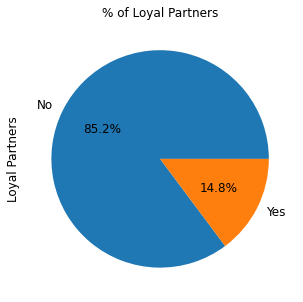

In [38]:
ax = (train['is_friend'].value_counts()*100.0 /len(train))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Loyal Partners',fontsize = 12)
ax.set_title('% of Loyal Partners', fontsize = 12)

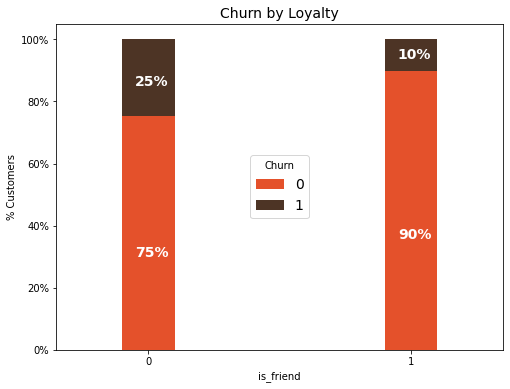

In [39]:
colors = ['#E4512B', '#4D3425']
loyal_churn = train.groupby(['is_friend','is_churn']).size().unstack()

ax = (loyal_churn.T*100.0 / loyal_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Loyalty',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

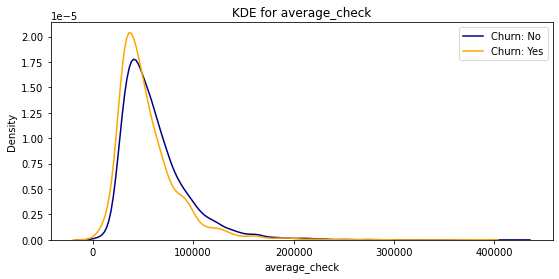

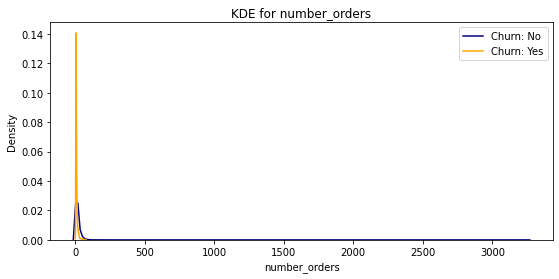

In [40]:
def kdeplot(df, feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['is_churn'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['is_churn'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes')
    plt.legend()
kdeplot(train, 'average_check')
kdeplot(train, 'number_orders')

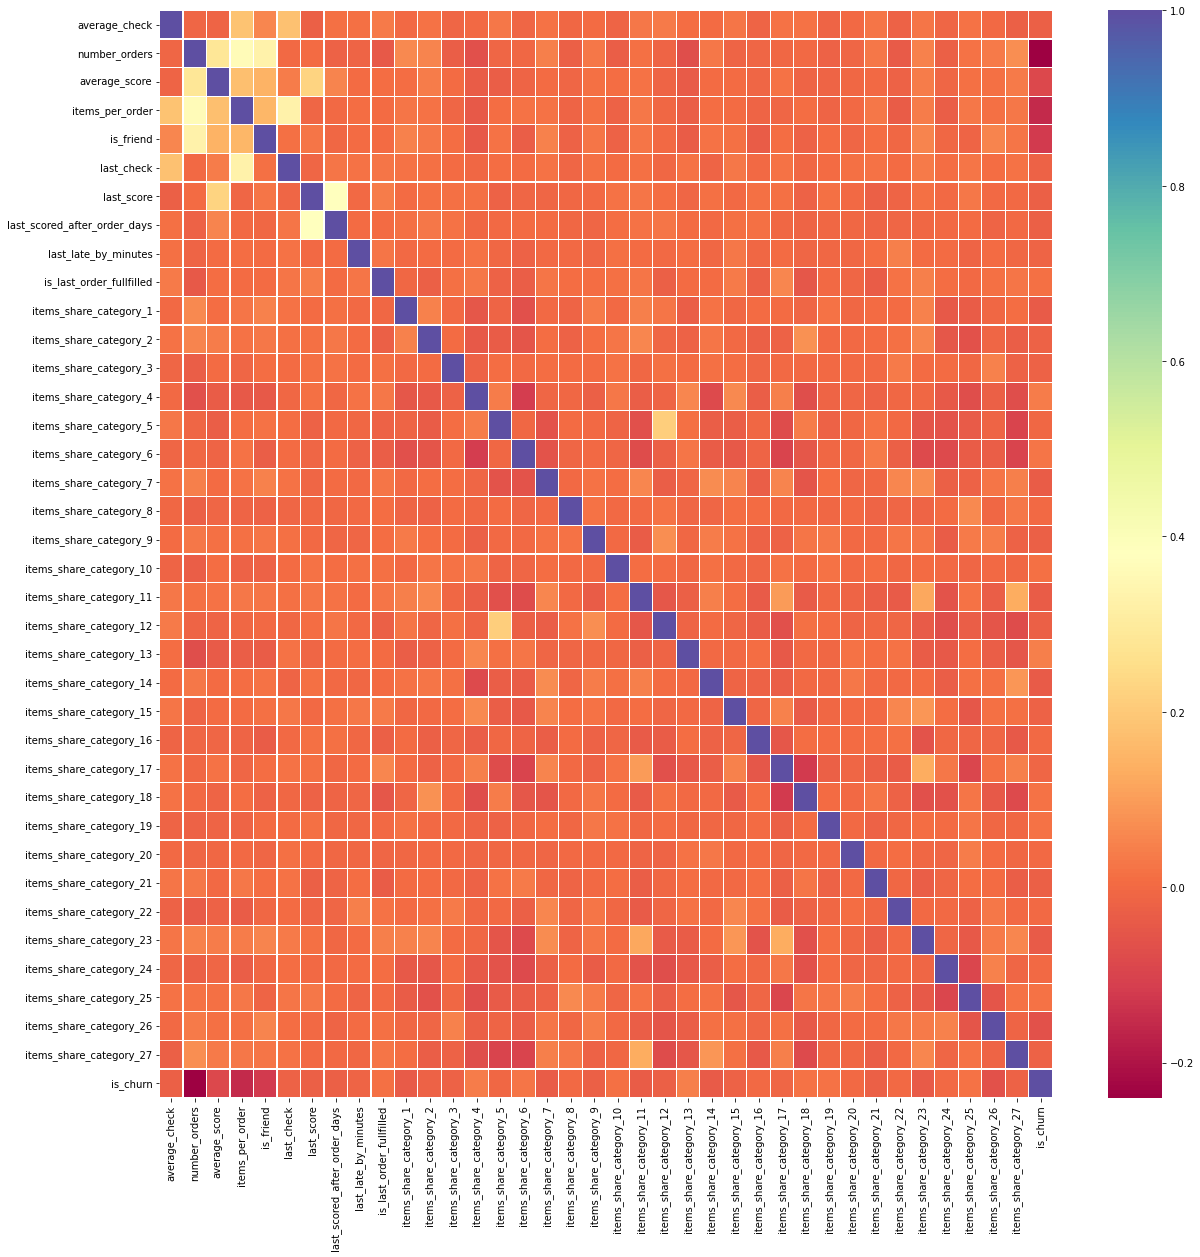

In [41]:
plt.figure(figsize=(20, 20))
df = train.drop(['client_id', ], axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="Spectral", annot=False)

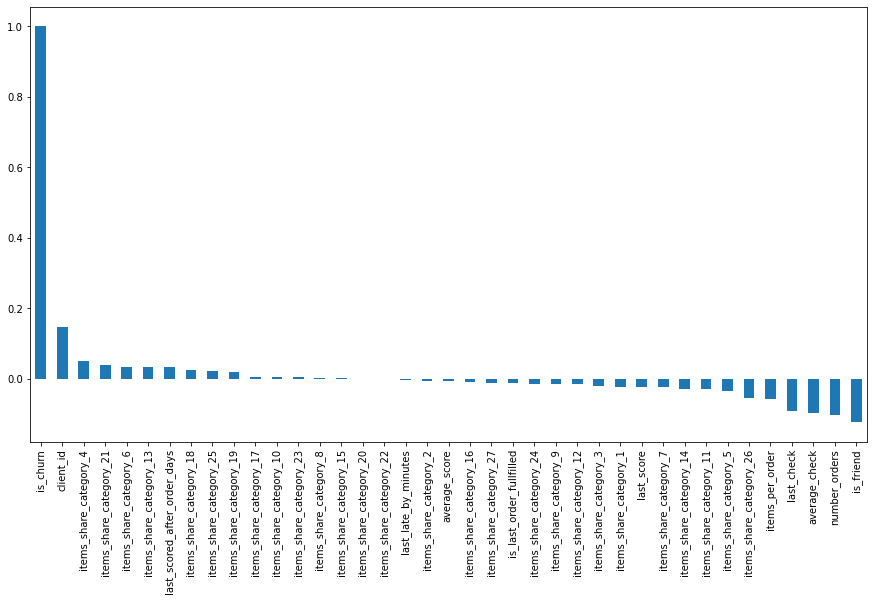

In [42]:
categories = ['items_share_category_'+str(i) for i in range(1,28)]
categories.append('is_churn')
conf_df = train.copy(categories)

plt.figure(figsize=(15,8))
conf_df.corr()['is_churn'].sort_values(ascending = False).plot(kind='bar')

# Data Preparation

In [44]:
items_share_category = [f'items_share_category_{i}' for i in range(1, 28)]
for_train = train.copy()
for_test = test.copy()

replace_value = 2.0

for_train.drop(['last_scored_after_order_days'], axis=1, inplace=True)
for_test.drop(['last_scored_after_order_days'], axis=1, inplace=True)

for_train['average_score'].replace({np.NaN: replace_value}, inplace=True)

for_train['last_score'].replace({np.NaN: replace_value}, inplace=True)

for_train['last_check'] = for_train['last_check'].fillna(for_train['last_check'].mean())


for_test['average_score'].replace({np.nan: replace_value}, inplace=True)

for_test['last_score'].replace({np.NaN: replace_value}, inplace=True)

for_test['last_check'] = for_test['last_check'].fillna(for_test['last_check'].mean())

drop_columns = ['is_churn', 'client_id']

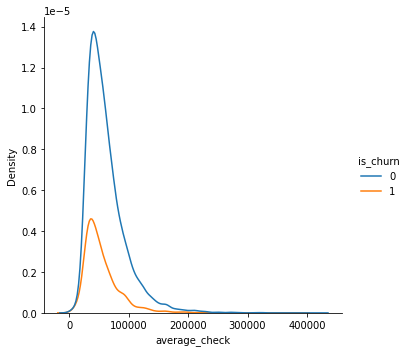

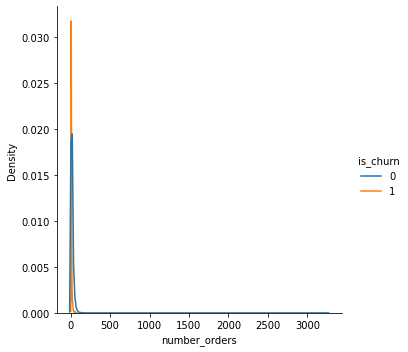

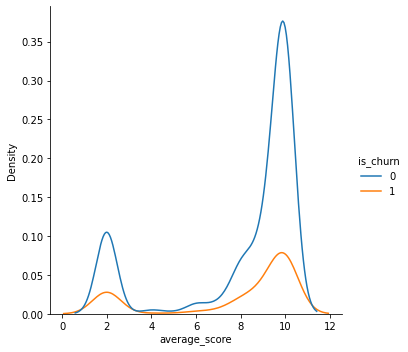

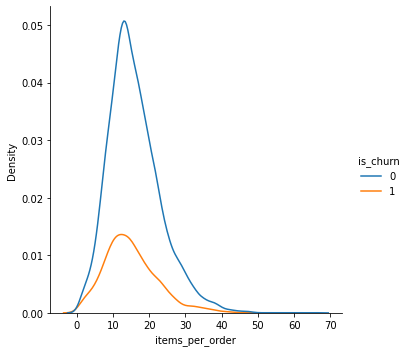

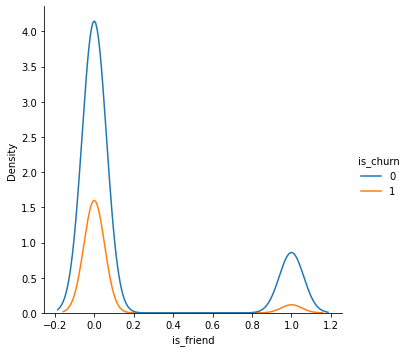

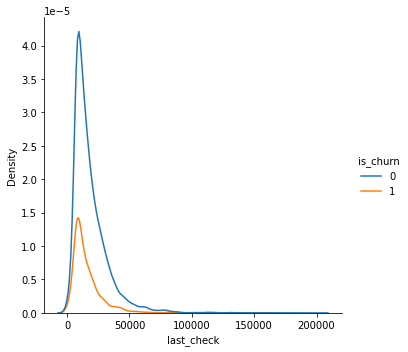

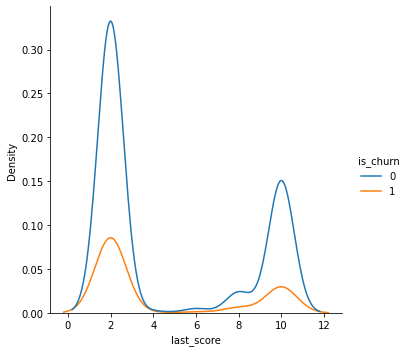

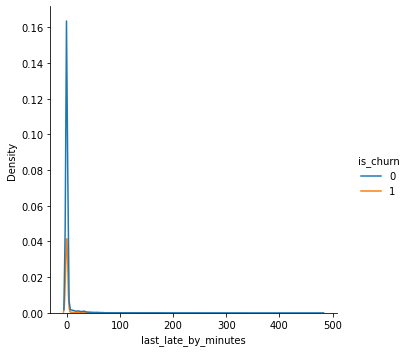

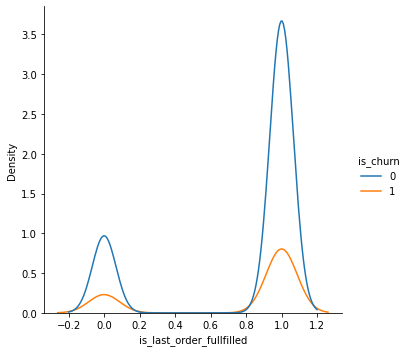

In [45]:
for col in for_train.columns[1:10]:
    sns.displot(data=for_train, x=col, hue="is_churn", kind="kde")

# Modeling and Evaluation

In [46]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=20)
X_train, X_test, y_train, y_test = train_test_split(for_train.drop(drop_columns, axis=1), for_train['is_churn'],
                                                    test_size=0.2, stratify=for_train['is_churn'])

X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

ct = ColumnTransformer(
    [('scaler', StandardScaler(), ['average_check', 'number_orders', 
                                   'last_score', 'last_check'
                                  ]),
    ], remainder='passthrough') 

X_scaled = ct.fit_transform(X_resampled)
X_test_scaled = ct.transform(X_test)

rfc = RandomForestClassifier(max_depth=10, n_estimators=200)

rfc.fit(X_scaled, y_resampled)
y_pred = rfc.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1701
           1       0.41      0.36      0.38       496

    accuracy                           0.74      2197
   macro avg       0.61      0.60      0.61      2197
weighted avg       0.73      0.74      0.73      2197



In [47]:
y_pred = rfc.predict(ct.transform(for_test.drop(['client_id'], axis=1)))
for_test['is_churn'] = y_pred
result = for_test[['client_id', 'is_churn']]

In [53]:
output = result[result['is_churn'] == 1]['client_id']
output.to_csv('output.csv', index=False)

# Extra

## Grid Search for Random Forest Parameters

In [ ]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}
scoring_metric = 'recall'
rf_clf = GridSearchCV(estimator=RandomForestClassifier(),
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_scaled, y_resampled)
print(best_rf_clf.best_estimator_)
y_pred = best_rf_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

## Neural Network Attempt

In [54]:
def dataTransformMean(train_df, is_test = False):
    x_train = train_df.copy()
    x_train['average_check'] = (x_train['average_check'] - x_train['average_check'].mean()) / x_train['average_check'].std()
    
    x_train['number_orders'] = (x_train['number_orders'] - x_train['number_orders'].mean()) / x_train['number_orders'].std()
    
    x_train['average_score'] = x_train['average_score'].fillna(x_train['average_score'].mean())

    x_train['average_score'] = (x_train['average_score'] - x_train['average_score'].mean())/x_train['average_score'].std()

    x_train['items_per_order'] = (x_train['items_per_order'] - x_train['items_per_order'].mean()) / x_train['items_per_order'].std()
    
    x_train['last_check'] = (x_train['last_check'] - x_train['last_check'].mean()) / x_train['last_check'].std()
    x_train['last_check'] = x_train['last_check'].fillna(0) 
    
    x_train['last_score'] = np.where(x_train['is_last_order_fullfilled'] == 1, x_train['last_score'].mean(), x_train['last_score'].min())
    
    x_train['last_score'] = (x_train['last_score'] - x_train['last_score'].mean())/x_train['last_score'].std()
    
    x_train['last_late_by_minutes'] = (x_train['last_late_by_minutes'] - x_train['last_late_by_minutes'].mean()) / x_train['last_late_by_minutes'].std()

    if not is_test:
        for col in ['average_check', 'last_late_by_minutes', 'number_orders', 'items_per_order', 'last_check']:
            x_train.drop(x_train[ abs(x_train[col]) > (2 * x_train[col].std()) ].index, inplace=True)

    x_train['average_check'] *= -1
    x_train['number_orders'] *= -1
    x_train['items_per_order'] *= -1
    x_train['last_check'] *= -1
    

    x_train = x_train.drop(['last_scored_after_order_days'], axis=1)

    return x_train

In [55]:
def splitData(df, split_size=0.2, seed = -1):
    df_0 = df.loc[df['is_churn'] == 0]
    df_1 = df.loc[df['is_churn'] == 1]
    
    train_df_0 = df_0.sample(frac=1-split_size)
    train_df_1 = df_1.sample(frac=1-split_size)
    
    test_df_0 = df_0[df_0['client_id'].isin(train_df_0['client_id'])==False]
    test_df_1 = df_1[df_1['client_id'].isin(train_df_1['client_id'])==False]
    
    train_df_0 = train_df_0.sample(frac=0.9)
    train_df = pd.concat([train_df_0,train_df_1])
    test_df = pd.concat([test_df_0,test_df_1])
    
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)
    
    y_train = train_df['is_churn']
    y_test = test_df['is_churn']
    x_train = train_df.drop(columns=['client_id','is_churn'])
    x_test = test_df.drop(columns=['client_id','is_churn'])
    
    return x_train, x_test, y_train, y_test


In [56]:
train_df = pd.read_csv(root+"ArbuzTrain.csv")
train_data = dataTransformMean(train_df)
x_train, x_test, y_train, y_test = splitData(train_data)

First inputs are main features such as 'number_orders', etc.

Second inputs are 'items_share_category_xx' 

In [60]:
from keras.models import Model
from keras.layers import Concatenate, Dense, Input, concatenate


lst = ['items_share_category_'+str(i) for i in range(1,28)]
input_of_b = x_train[lst]
input_of_a = x_train.drop(lst, axis = 1)

first_input = Input(shape=input_of_a.shape[1])
first_dense = Dense(6, activation='relu')(first_input)

second_input = Input(shape=input_of_b.shape[1])
second_dense = Dense(1, activation='relu')(second_input)

merge_one = concatenate([first_dense, second_dense])

third_dense = Dense(4, activation='relu')(merge_one)
forth_dense = Dense(2, activation='relu')(third_dense)
last_dense = Dense(1, activation='sigmoid')(forth_dense)

nn2_model = Model(inputs=[first_input, second_input], outputs=last_dense)

nn2_model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

In [61]:
nn2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 6)            60          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            28          ['input_2[0][0]']                
                                                                                              

In [62]:
hst = nn2_model.fit([input_of_a, input_of_b], y_train, epochs=100)

Epoch 1/100
214/214 [==============================] - 2s 2ms/step - loss: 0.6738 - accuracy: 0.6836
Epoch 2/100
214/214 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.7500
Epoch 3/100
214/214 [==============================] - 0s 2ms/step - loss: 0.6079 - accuracy: 0.7500
Epoch 4/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7500
Epoch 5/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.7500
Epoch 6/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.7500
Epoch 7/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7500
Epoch 8/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7500
Epoch 9/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5638 - accuracy: 0.7500
Epoch 10/100
214/214 [==============================] - 0s 2ms/step - loss: 0.5631 - accura

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

test_df = pd.read_csv(root+"ArbuzTest.csv")
test_data = dataTransformMean(test_df, True)

lst = ['items_share_category_'+str(i) for i in range(1,28)]
test_b = x_test[lst]
test_a = x_test.drop(lst, axis = 1)


test_set_pred = nn2_model.predict([test_a,test_b])
test_set_pred = np.around(test_set_pred)

print('\n')
print('Accuracy for test set: %0.4f' % accuracy_score(y_test, test_set_pred))

58/58 [==============================] - 0s 5ms/step


Accuracy for test set: 0.7692


## XGBoost Attempt

In [65]:
from xgboost import XGBClassifier
from sklearn import metrics 

xgmodel = XGBClassifier(objective= 'binary:logistic')

In [ ]:
%%time

params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 270, 40),
    'learning_rate': [0.1, 0.001]
}

grid_search = GridSearchCV(
    estimator=xgmodel,
    param_grid=params,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = 5,
    verbose=0
)
grid_result = grid_search.fit(input_of_a, y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [ ]:
xgmodel = XGBClassifier(objective= 'binary:logistic', learning_rate=0.1, max_depth=9, n_estimators=260)
xgmodel.fit(input_of_a, y_train)

In [ ]:
xg_test = x_test.drop(lst,axis=1)
preds = xgmodel.predict(xg_test)

print("Accuracy:  %0.4f" % metrics.accuracy_score(y_test, preds))
print("Precision: %0.4f" % metrics.precision_score(y_test, preds))
print("Recall: %0.4f" % metrics.recall_score(y_test, preds))
print("F1: %0.4f\n" % metrics.f1_score(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))
